In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [184]:
# %load /tigress/changgoo/pyathena-TIGRESS/pyathena/yt_analysis/ytathena.py
from yt import add_field
from yt import YTQuantity
from yt.utilities.physical_constants import \
    mh, \
    me, \
    sigma_thompson, \
    clight, \
    kboltz, \
    G
import pickle as p
import numpy as np
import pyathena as pa

# basic qunatities with renormalization
def _ndensity(field, data):
        return data["gas","density"]/(1.4271*mh)

def _ram_pok_z(field,data):
        return data["gas","density"]*data["gas","velocity_z"]**2/kboltz

def _turb_pok(field,data):
        return data["gas","density"]*data["gas","velocity_magnitude"]**2/kboltz

# thermodynamics quantities
def _pok(field, data):
        return data["gas","pressure"]/kboltz

def _cs(field, data):
        return np.sqrt(data["gas","pressure"]/data["gas","density"])

def _T1(field, data):
        return data["gas","pressure"]/data["gas","density"]*mh/kboltz

def _mu(field, data):
        cf=pa.coolftn()
        T1=data["gas","T1"].d
        temp=cf.get_temp(T1)
        return temp/T1

def _temperature(field,data):
        return data["gas","T1"]*data["gas","mu"]

# rotation
Omega=YTQuantity(28,"km/s/kpc")
def _dvelocity(field,data):
        return data["gas","velocity_y"]+data["gas","x"]*Omega

def _dvelocity_mag(field,data):
        return np.sqrt(data["gas","velocity_x"]**2+data["gas","dvelocity_y"]**2+data["gas","velocity_z"]**2)

def _dkinetic_energy(field,data):
    return 0.5*data['gas','dvelocity_magnitude']**2*data['gas','density']

# magnetic fields
def _mag_pok(field,data):
        return data["gas","magnetic_pressure"]/kboltz

# metals
def _metallicity(field,data):
        return data["athena","specific_scalar[0]"]

def _metal(field,data):
        return data["athena","specific_scalar[0]"]*data["gas","density"]

def _metal_cl(field,data):
        return data["athena","specific_scalar[1]"]*data["gas","density"]

def _metal_run(field,data):
        return data["athena","specific_scalar[2]"]*data["gas","density"]

def _radius(field, data):
    return np.sqrt(data['x']**2+data['y']**2+data['z']**2)

def _velocity_r(field, data):
    return data['velocity_x']*data['x']/data['radius']+\
           data['velocity_y']*data['y']/data['radius']+\
           data['velocity_z']*data['z']/data['radius']

def _momentum_r(field, data):
    return data["cell_mass"]*data["velocity_r"]

def _total_kinetic_energy(field, data):
    return 0.5*data["cell_mass"]*data["velocity_magnitude"]**2

def _total_magnetic_energy(field, data):
    return data["magnetic_field_magnitude"]**2*data["cell_volume"]/8.0/np.pi

def get_scalars(ds):
    scal_fields=[]
    for f in ds.field_list: 
        code,field=f
        if field.startswith('specific_scalar'):
            scal_fields.append(field)

    return scal_fields


def add_yt_fields(ds,cooling=True,mhd=True,rotation=True):
    ds.add_field(("gas","nH"),function=_ndensity,sampling_type='cell', \
      units='cm**(-3)',display_name=r'n_{\rm H}')
    ds.add_field(("gas","ram_pok_z"),function=_ram_pok_z,sampling_type='cell', \
      units='K*cm**(-3)',display_name=r'$P_{\rm turb,z}/k_{\rm B}$')
    ds.add_field(("gas","turb_pok"),function=_turb_pok,sampling_type='cell', \
      units='K*cm**(-3)',display_name=r'$P_{\rm turb}/k_{\rm B}$')
    ds.add_field(("gas","radius"), function=_radius, \
      sampling_type='cell',units='pc', \
      display_name=r'$r$',force_override=True)
    ds.add_field(("gas","total_kinetic_energy"), function=_total_kinetic_energy, \
      sampling_type='cell',units='erg', \
      display_name=r'$E_{\rm kin}$',force_override=True)
    ds.add_field(("gas","velocity_r"), function=_velocity_r, \
      sampling_type='cell',units='km/s', display_name=r'$v_r$')
    ds.add_field(("gas","momentum_r"), function=_momentum_r, \
      sampling_type='cell',units='Msun*km/s', display_name=r'$p_r$')
    if cooling:
        ds.add_field(("gas","pok"),function=_pok,sampling_type='cell', \
          units='K*cm**(-3)',display_name=r'$P/k_{\rm B}$')
        ds.add_field(("gas","cs"),function=_cs,sampling_type='cell', \
          units='km*s**(-1)',display_name=r'$c_s$')
        ds.add_field(("gas","T1"),function=_T1,sampling_type='cell', \
          units='K',display_name=r'$T_1$')
        ds.add_field(("gas","mu"),function=_mu,sampling_type='cell', \
          units='',display_name=r'$\mu$',force_override=True)
        ds.add_field(("gas","temperature"),function=_temperature,sampling_type='cell', \
          units='K',display_name=r'T',force_override=True)
    if rotation:
        ds.add_field(("gas","dvelocity_y"),function=_dvelocity,sampling_type='cell', \
          units='km/s',display_name=r'$\delta v_y$',force_override=True)
        ds.add_field(("gas","dvelocity_magnitude"),function=_dvelocity_mag,sampling_type='cell', \
          units='km/s',display_name=r'$v$',force_override=True)
        ds.add_field(("gas","dkinetic_energy"),function=_dkinetic_energy,sampling_type='cell', \
          units='erg/cm**3',display_name=r'$E_k$',force_override=True)
    if mhd:
        ds.add_field(("gas","mag_pok"),function=_mag_pok,sampling_type='cell', \
          units='K*cm**(-3)',display_name=r'$P_{\rm mag}/k_{\rm B}$')
        ds.add_field(("gas","total_magnetic_energy"), function=_total_magnetic_energy, \
          sampling_type='cell', \
          units='erg', display_name=r'$E_{\rm mag}$',force_override=True)

    scal_fields=get_scalars(ds)
    if len(scal_fields)>0:
        ds.add_field(("gas","metallicity"),function=_metallicity,sampling_type='cell', \
          units='dimensionless',display_name=r'$Z$')
        ds.add_field(("gas","metal0"),function=_metal,sampling_type='cell', \
          units='g*cm**(-3)',display_name=r'$\rho_{\rm metal}$')
    if len(scal_fields)>1:
        ds.add_field(("gas","metal1"),function=_metal_cl,sampling_type='cell', \
          units='g*cm**(-3)',display_name=r'$\rho_{\rm metal,cl}$')
    if len(scal_fields)>2:
        ds.add_field(("gas","metal2"),function=_metal_run,sampling_type='cell', \
          units='g*cm**(-3)',display_name=r'$\rho_{\rm metal,run}$')
        
def ytload(filename):
    
    unit_base={"length_unit": (1.0,"pc"), 
               "time_unit": (1.0,"s*pc/km"), 
               "mass_unit": (2.38858753789e-24,"g/cm**3*pc**3"), 
               "velocity_unit": (1.0,"km/s"),
               "magnetic_unit": (5.4786746797e-07,"gauss")}

    tigress_unit_system=yt.UnitSystem('tigress','pc','Msun','Myr',)
    tigress_unit_system['velocity']='km/s'
    tigress_unit_system['magnetic_field']='uG'
    ds=yt.load(filename,units_override=unit_base,unit_system=tigress_unit_system)
    add_yt_fields(ds,cooling=True,mhd=True,rotation=False)
    
    return ds

In [268]:
from yt.visualization.volume_rendering.api import Scene, VolumeSource

In [269]:
def linramp(vals, minval, maxval):
    return (vals - vals.min())/(vals.max() - vals.min())

In [272]:
def add_volume(ds,sc,field='temperature',bounds=(1,1.e9),colormap='cubehelic'):
    vol= VolumeSource(ds, field=field)

    sc.add_source(vol)

    source=sc[-1]
    source.set_log(True)

    bounds = bounds

    tf = yt.ColorTransferFunction(np.log10(bounds))

    tf.map_to_colormap(np.log10(bounds[0]), np.log10(bounds[1]), colormap=colormap,
                       scale_func=linramp)

    source.tfh.tf = tf
    source.tfh.bounds = bounds

    # this is useful for low-resolution data
    #source.set_use_ghost_zones(True)


# High resolution model

In [ ]:
ds = ytload('/tigress/changgoo/R8_2pc_rst/id0/R8_2pc_rst.0300.vtk')

yt : [INFO     ] 2019-01-02 17:15:41,903 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 17:15:41,910 Creating volume


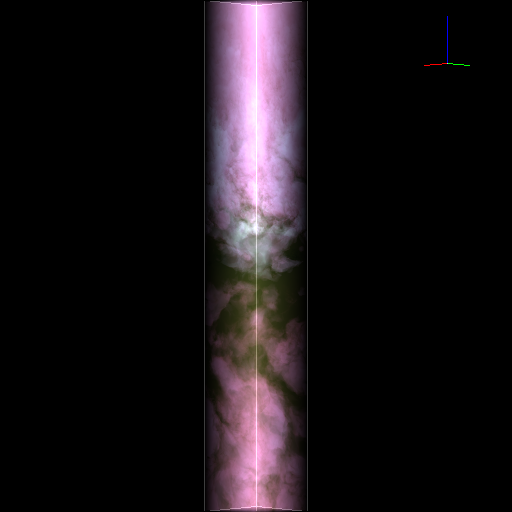

In [271]:
sc = Scene()

#add_volume(ds,sc,field='nH',bounds=(1.e-4,1.e2),colormap='bone_r')
add_volume(ds,sc,field='temperature',bounds=(1,1.e9),colormap='cubehelix')

###############################################################
# setting for camera
###############################################################

cam = sc.add_camera(ds)
cam.position = ds.arr([1024,1024,128],'code_length')
#normal_vector = [0.1,0.1, 1.]
north_vector = [0.1,0.1,1.]
#cam.set_focus(ds.domain_center)
cam.switch_orientation(north_vector=north_vector)
#cam.set_width(ds.domain_width)
cam.zoom(1.5)

sc.annotate_domain(ds,[1,1,1,0.01])
sc.annotate_axes(alpha=0.1)
sc.show(sigma_clip=2.0)

yt : [INFO     ] 2019-01-02 17:30:09,173 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 17:30:13,528 Creating volume


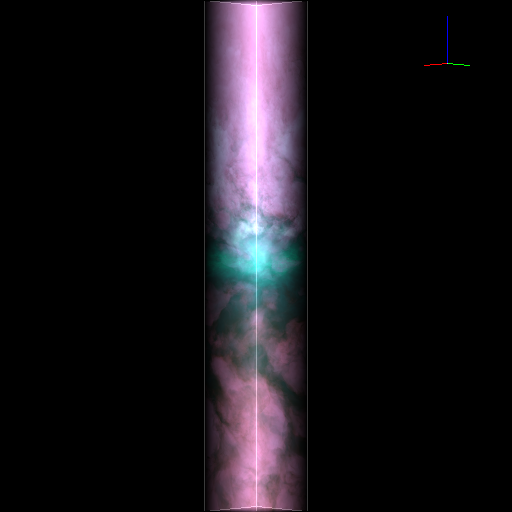

yt : [INFO     ] 2019-01-02 17:32:30,479 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 17:32:39,763 Saving render R8_2pc_rst.0300.rotate_0000.png


In [273]:
#sc = Scene()

add_volume(ds,sc,field='nH',bounds=(1.e-4,1.e2),colormap='winter')
#add_volume(ds,sc,field='temperature',bounds=(1,1.e9),colormap='cubehelix')

###############################################################
# setting for camera
###############################################################

cam = sc.add_camera(ds)
cam.position = ds.arr([1024,1024,128],'code_length')
#normal_vector = [0.1,0.1, 1.]
north_vector = [0.1,0.1,1.]
#cam.set_focus(ds.domain_center)
cam.switch_orientation(north_vector=north_vector)
#cam.set_width(ds.domain_width)
cam.zoom(1.5)

sc.render()
sc.annotate_domain(ds,[1,1,1,0.01])
sc.annotate_axes(alpha=0.1)
sc.show(sigma_clip=2.0)

yt : [INFO     ] 2019-01-02 17:43:47,739 Rendering scene (Can take a while).


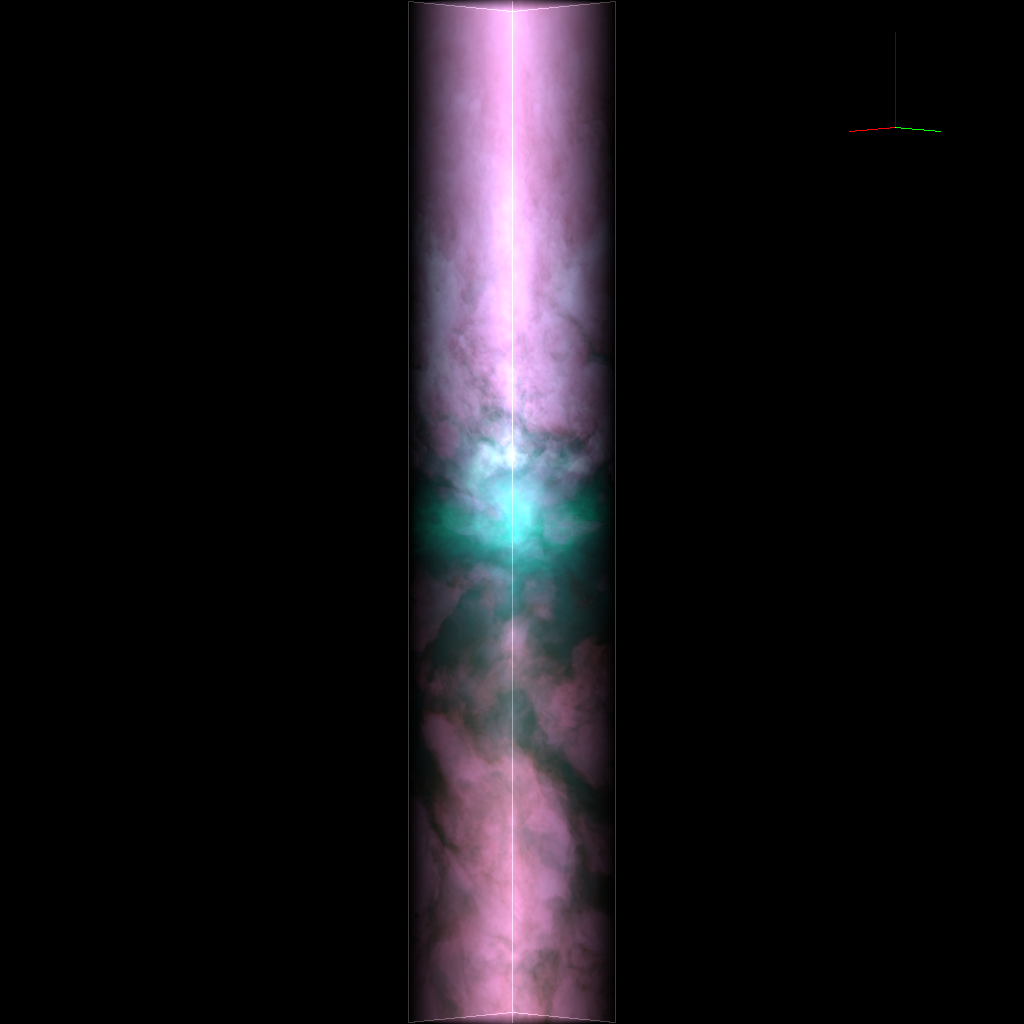

In [274]:
cam.set_resolution(1024)
sc.render()
sc.show(sigma_clip=2.0)

# Rotating Camera

In [276]:
frame=0
for _ in cam.iter_rotate(2.*np.pi, 256):
    sc.save('rendering_%04i.png' % frame,sigma_clip=2.0)
    frame += 1

yt : [INFO     ] 2019-01-02 17:46:51,605 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 17:47:23,475 Saving render rendering_0000.png
yt : [INFO     ] 2019-01-02 17:47:24,495 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 17:48:02,031 Saving render rendering_0001.png
yt : [INFO     ] 2019-01-02 17:48:03,218 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 17:48:42,451 Saving render rendering_0002.png
yt : [INFO     ] 2019-01-02 17:48:43,550 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 17:49:18,258 Saving render rendering_0003.png
yt : [INFO     ] 2019-01-02 17:49:19,307 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 17:49:53,157 Saving render rendering_0004.png
yt : [INFO     ] 2019-01-02 17:49:54,235 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 17:50:30,793 Saving render rendering_0005.png
yt : [INFO     ] 2019-01-02 17:50:31,931 Rendering scene (Can take a while).
yt : [INFO     ] 

yt : [INFO     ] 2019-01-02 18:11:32,682 Saving render rendering_0054.png
yt : [INFO     ] 2019-01-02 18:11:33,708 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:12:00,400 Saving render rendering_0055.png
yt : [INFO     ] 2019-01-02 18:12:01,459 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:12:28,767 Saving render rendering_0056.png
yt : [INFO     ] 2019-01-02 18:12:29,803 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:12:57,944 Saving render rendering_0057.png
yt : [INFO     ] 2019-01-02 18:12:59,062 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:13:25,323 Saving render rendering_0058.png
yt : [INFO     ] 2019-01-02 18:13:26,391 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:13:52,459 Saving render rendering_0059.png
yt : [INFO     ] 2019-01-02 18:13:53,503 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:14:21,115 Saving render rendering_0060.png
yt : [INFO     ] 201

yt : [INFO     ] 2019-01-02 18:35:40,748 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:36:20,732 Saving render rendering_0109.png
yt : [INFO     ] 2019-01-02 18:36:21,754 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:36:54,022 Saving render rendering_0110.png
yt : [INFO     ] 2019-01-02 18:36:55,019 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:37:29,830 Saving render rendering_0111.png
yt : [INFO     ] 2019-01-02 18:37:30,931 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:37:57,414 Saving render rendering_0112.png
yt : [INFO     ] 2019-01-02 18:37:58,434 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:38:22,168 Saving render rendering_0113.png
yt : [INFO     ] 2019-01-02 18:38:23,133 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:38:49,099 Saving render rendering_0114.png
yt : [INFO     ] 2019-01-02 18:38:50,070 Rendering scene (Can take a while).
yt : [INFO     ] 

yt : [INFO     ] 2019-01-02 18:59:18,637 Saving render rendering_0163.png
yt : [INFO     ] 2019-01-02 18:59:19,644 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 18:59:43,478 Saving render rendering_0164.png
yt : [INFO     ] 2019-01-02 18:59:44,483 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:00:08,569 Saving render rendering_0165.png
yt : [INFO     ] 2019-01-02 19:00:09,596 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:00:34,604 Saving render rendering_0166.png
yt : [INFO     ] 2019-01-02 19:00:35,548 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:01:01,968 Saving render rendering_0167.png
yt : [INFO     ] 2019-01-02 19:01:03,054 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:01:27,591 Saving render rendering_0168.png
yt : [INFO     ] 2019-01-02 19:01:28,546 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:01:53,352 Saving render rendering_0169.png
yt : [INFO     ] 201

yt : [INFO     ] 2019-01-02 19:14:16,631 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:14:26,039 Saving render rendering_0218.png
yt : [INFO     ] 2019-01-02 19:14:26,965 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:14:42,436 Saving render rendering_0219.png
yt : [INFO     ] 2019-01-02 19:14:43,409 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:14:55,013 Saving render rendering_0220.png
yt : [INFO     ] 2019-01-02 19:14:55,957 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:15:05,500 Saving render rendering_0221.png
yt : [INFO     ] 2019-01-02 19:15:06,495 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:15:17,454 Saving render rendering_0222.png
yt : [INFO     ] 2019-01-02 19:15:18,438 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-02 19:15:27,895 Saving render rendering_0223.png
yt : [INFO     ] 2019-01-02 19:15:28,879 Rendering scene (Can take a while).
yt : [INFO     ] 

In [278]:
import pyathena.plot_tools.movie as movie
movie.make_movie('rendering_????.png','R8_2pc_rst.0300.rotate.mp4')

[make_mp4]: ffmpeg command:
ffmpeg -y -r 15 -f image2 -pattern_type glob -i rendering_????.png -r 15 -pix_fmt yuv420p -vcodec libx264 -vf scale=trunc(iw/2)*2:trunc(ih/2)*2 -f mp4 R8_2pc_rst.0300.rotate.mp4
[make_movie]: Successful execution. Output:
R8_2pc_rst.0300.rotate.mp4


# Time Series

In [ ]:
import glob,os
pid='R8_8pc_rst'
files=glob.glob('/tigress/changgoo/{}/id0/{}.????.vtk'.format(pid,pid))
files.sort()
dirname=os.path.dirname(files[0]).replace('id0','volume/')
if not os.path.isdir(dirname): os.mkdir(dirname)
print(dirname)

In [ ]:
for f in files:
    ds = ytload(f)
    sc = Scene()

    add_volume(ds,sc,field='nH',bounds=(1.e-4,1.e2),colormap='winter')
    add_volume(ds,sc,field='temperature',bounds=(1,1.e9),colormap='cubehelix')

    ###############################################################
    # setting for camera
    ###############################################################

    cam = sc.add_camera(ds)
    cam.position = ds.arr([1024,1024,128],'code_length')
    #normal_vector = [0.1,0.1, 1.]
    north_vector = [0.1,0.1,1.]
    #cam.set_focus(ds.domain_center)
    cam.switch_orientation(north_vector=north_vector)
    #cam.set_width(ds.domain_width)
    cam.set_resolution(1024)
    cam.zoom(1.4)

    sc.render()
    sc.annotate_domain(ds,[1,1,1,0.01])
    sc.annotate_axes(alpha=0.1)

    sc.save(f.replace('id0','volume').replace('vtk','volume.png'),sigma_clip=2.0)

yt : [INFO     ] 2019-01-03 10:17:32,885 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:17:32,897 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:17:32,897 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:17:32,898 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:17:32,899 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:17:32,900 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:17:32,901 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:17:32,912 Parameters: current_time              = 285.7147
yt : [INFO     ] 2019-01-03 10:17:32,912 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:17:32,913 Parameters: domain_left_edge          = [ -512.  -512. -35

yt : [INFO     ] 2019-01-03 10:18:40,589 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:18:40,590 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:18:40,591 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:18:40,592 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:18:40,593 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:18:40,605 Parameters: current_time              = 290.0
yt : [INFO     ] 2019-01-03 10:18:40,606 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:18:40,606 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:18:40,607 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:18:40,607 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:18:42,776 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:18:42,791 Creating vo

yt : [INFO     ] 2019-01-03 10:19:44,617 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:19:44,628 Parameters: current_time              = 295.0008
yt : [INFO     ] 2019-01-03 10:19:44,629 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:19:44,629 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:19:44,630 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:19:44,631 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:19:46,701 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:19:46,710 Creating volume
yt : [INFO     ] 2019-01-03 10:19:49,295 Creating volume
yt : [INFO     ] 2019-01-03 10:19:54,222 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:19:55,869 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0295.volume.png
yt : [INFO     ] 2019-01-03 10:19:56,945 Temporari

yt : [INFO     ] 2019-01-03 10:20:51,044 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:20:51,044 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:20:54,351 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:20:54,366 Creating volume
yt : [INFO     ] 2019-01-03 10:20:56,980 Creating volume
yt : [INFO     ] 2019-01-03 10:21:03,328 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:21:04,929 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0300.volume.png
yt : [INFO     ] 2019-01-03 10:21:05,983 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:21:05,995 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:21:05,995 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:21:

yt : [INFO     ] 2019-01-03 10:22:11,960 Creating volume
yt : [INFO     ] 2019-01-03 10:22:18,912 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:22:20,553 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0305.volume.png
yt : [INFO     ] 2019-01-03 10:22:22,159 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:22:22,171 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:22:22,171 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:22:22,172 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:22:22,173 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:22:22,174 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:22:22,174 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:2

yt : [WARNING  ] 2019-01-03 10:23:39,194 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:23:39,194 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:23:39,195 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:23:39,196 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:23:39,197 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:23:39,198 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:23:39,209 Parameters: current_time              = 311.0006
yt : [INFO     ] 2019-01-03 10:23:39,210 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:23:39,210 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:23:39,211 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:23:39,211 Parameters

yt : [INFO     ] 2019-01-03 10:25:06,041 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:25:06,042 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:25:06,043 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:25:06,054 Parameters: current_time              = 316.0007
yt : [INFO     ] 2019-01-03 10:25:06,055 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:25:06,055 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:25:06,056 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:25:06,057 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:25:08,897 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:25:08,905 Creating volume
yt : [INFO     ] 2019-01-03 10:25:11,193 Creating volume
yt : [INFO     ] 2019-01-03 10:25:16,887 Rendering scene (Can take a while).
yt 

yt : [INFO     ] 2019-01-03 10:26:20,566 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:26:20,567 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:26:20,568 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:26:20,569 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:26:23,913 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:26:23,923 Creating volume
yt : [INFO     ] 2019-01-03 10:26:29,016 Creating volume
yt : [INFO     ] 2019-01-03 10:26:36,725 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:26:42,716 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0321.volume.png
yt : [INFO     ] 2019-01-03 10:26:43,997 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:26:44,008 Overriding code units: Us

yt : [INFO     ] 2019-01-03 10:27:33,331 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:27:35,623 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:27:35,636 Creating volume
yt : [INFO     ] 2019-01-03 10:27:38,264 Creating volume
yt : [INFO     ] 2019-01-03 10:27:43,173 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:27:45,020 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0326.volume.png
yt : [INFO     ] 2019-01-03 10:27:46,235 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:27:46,247 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:27:46,247 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:27:46,248 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:27:46,249 Overriding mass_unit: 2

yt : [INFO     ] 2019-01-03 10:28:59,841 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0331.volume.png
yt : [INFO     ] 2019-01-03 10:29:01,077 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:29:01,089 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:29:01,090 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:29:01,091 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:29:01,092 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:29:01,093 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:29:01,094 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:29:01,105 Parameters: current_time              = 332.0005
yt : [INFO     ] 2019-01-03 10:29:01,106 Parameters: domain_dimensions      

yt : [INFO     ] 2019-01-03 10:30:08,132 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:30:08,133 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:30:08,134 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:30:08,135 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:30:08,136 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:30:08,147 Parameters: current_time              = 337.0024
yt : [INFO     ] 2019-01-03 10:30:08,148 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:30:08,148 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:30:08,149 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:30:08,150 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:30:10,858 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:30:10,868 Creating

yt : [INFO     ] 2019-01-03 10:31:34,904 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:31:34,916 Parameters: current_time              = 342.001
yt : [INFO     ] 2019-01-03 10:31:34,917 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:31:34,917 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:31:34,918 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:31:34,918 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:31:38,357 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:31:38,366 Creating volume
yt : [INFO     ] 2019-01-03 10:31:41,682 Creating volume
yt : [INFO     ] 2019-01-03 10:31:47,998 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:31:49,841 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0342.volume.png
yt : [INFO     ] 2019-01-03 10:31:50,935 Temporaril

yt : [INFO     ] 2019-01-03 10:32:59,786 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:32:59,786 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:33:02,207 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:33:02,223 Creating volume
yt : [INFO     ] 2019-01-03 10:33:04,117 Creating volume
yt : [INFO     ] 2019-01-03 10:33:08,895 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:33:10,337 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0347.volume.png
yt : [INFO     ] 2019-01-03 10:33:11,449 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:33:11,461 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:33:11,461 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:33:

yt : [INFO     ] 2019-01-03 10:34:22,210 Creating volume
yt : [INFO     ] 2019-01-03 10:34:28,782 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:34:30,746 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0352.volume.png
yt : [INFO     ] 2019-01-03 10:34:31,862 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:34:31,874 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:34:31,874 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:34:31,875 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:34:31,876 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:34:31,877 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:34:31,878 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:3

yt : [WARNING  ] 2019-01-03 10:35:34,111 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:35:34,112 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:35:34,112 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:35:34,113 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:35:34,114 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:35:34,115 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:35:34,126 Parameters: current_time              = 358.0004
yt : [INFO     ] 2019-01-03 10:35:34,127 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:35:34,127 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:35:34,128 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:35:34,129 Parameters

yt : [INFO     ] 2019-01-03 10:36:43,032 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:36:43,033 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:36:43,034 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:36:43,049 Parameters: current_time              = 363.0002
yt : [INFO     ] 2019-01-03 10:36:43,049 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:36:43,050 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:36:43,050 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:36:43,051 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:36:45,152 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:36:45,163 Creating volume
yt : [INFO     ] 2019-01-03 10:36:49,748 Creating volume
yt : [INFO     ] 2019-01-03 10:36:58,725 Rendering scene (Can take a while).
yt 

yt : [INFO     ] 2019-01-03 10:38:06,150 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:38:06,151 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:38:06,151 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:38:06,152 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:38:08,611 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:38:08,623 Creating volume
yt : [INFO     ] 2019-01-03 10:38:11,610 Creating volume
yt : [INFO     ] 2019-01-03 10:38:16,770 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:38:18,902 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0368.volume.png
yt : [INFO     ] 2019-01-03 10:38:20,115 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:38:20,127 Overriding code units: Us

yt : [INFO     ] 2019-01-03 10:39:35,008 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:39:37,698 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:39:37,714 Creating volume
yt : [INFO     ] 2019-01-03 10:39:40,047 Creating volume
yt : [INFO     ] 2019-01-03 10:39:45,538 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:39:47,238 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0373.volume.png
yt : [INFO     ] 2019-01-03 10:39:48,356 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:39:48,368 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:39:48,368 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:39:48,369 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:39:48,370 Overriding mass_unit: 2

yt : [INFO     ] 2019-01-03 10:40:52,600 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0378.volume.png
yt : [INFO     ] 2019-01-03 10:40:53,726 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:40:53,738 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:40:53,739 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:40:53,739 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:40:53,740 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:40:53,741 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:40:53,742 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:40:53,753 Parameters: current_time              = 379.001
yt : [INFO     ] 2019-01-03 10:40:53,754 Parameters: domain_dimensions       

yt : [INFO     ] 2019-01-03 10:42:01,495 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:42:01,496 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:42:01,497 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:42:01,498 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:42:01,499 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:42:01,510 Parameters: current_time              = 384.0002
yt : [INFO     ] 2019-01-03 10:42:01,510 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:42:01,511 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:42:01,512 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:42:01,512 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:42:04,209 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:42:04,216 Creating

yt : [INFO     ] 2019-01-03 10:43:10,001 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:43:10,012 Parameters: current_time              = 389.0012
yt : [INFO     ] 2019-01-03 10:43:10,012 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:43:10,013 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:43:10,014 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:43:10,015 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:43:12,805 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:43:12,812 Creating volume
yt : [INFO     ] 2019-01-03 10:43:15,295 Creating volume
yt : [INFO     ] 2019-01-03 10:43:21,263 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:43:23,124 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0389.volume.png
yt : [INFO     ] 2019-01-03 10:43:24,272 Temporari

yt : [INFO     ] 2019-01-03 10:44:26,906 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:44:26,906 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:44:29,311 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:44:29,321 Creating volume
yt : [INFO     ] 2019-01-03 10:44:31,789 Creating volume
yt : [INFO     ] 2019-01-03 10:44:36,883 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:44:39,099 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0394.volume.png
yt : [INFO     ] 2019-01-03 10:44:40,291 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:44:40,305 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:44:40,305 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:44:

yt : [INFO     ] 2019-01-03 10:45:48,608 Creating volume
yt : [INFO     ] 2019-01-03 10:45:56,177 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:45:58,398 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0399.volume.png
yt : [INFO     ] 2019-01-03 10:45:59,560 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:45:59,575 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:45:59,575 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:45:59,576 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:45:59,577 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:45:59,579 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:45:59,580 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:4

yt : [WARNING  ] 2019-01-03 10:47:20,665 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:47:20,666 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:47:20,667 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:47:20,669 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:47:20,670 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:47:20,671 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:47:20,685 Parameters: current_time              = 405.0004
yt : [INFO     ] 2019-01-03 10:47:20,686 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:47:20,687 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:47:20,688 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:47:20,688 Parameters

yt : [INFO     ] 2019-01-03 10:48:38,600 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:48:38,601 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:48:38,602 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:48:38,618 Parameters: current_time              = 410.0002
yt : [INFO     ] 2019-01-03 10:48:38,619 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:48:38,619 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:48:38,620 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:48:38,621 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:48:40,927 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:48:40,942 Creating volume
yt : [INFO     ] 2019-01-03 10:48:43,957 Creating volume
yt : [INFO     ] 2019-01-03 10:48:49,626 Rendering scene (Can take a while).
yt 

yt : [INFO     ] 2019-01-03 10:49:50,279 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:49:50,280 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:49:50,281 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:49:50,282 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:49:52,580 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:49:52,592 Creating volume
yt : [INFO     ] 2019-01-03 10:49:55,470 Creating volume
yt : [INFO     ] 2019-01-03 10:50:01,283 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:50:03,529 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0415.volume.png
yt : [INFO     ] 2019-01-03 10:50:04,742 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:50:04,756 Overriding code units: Us

yt : [INFO     ] 2019-01-03 10:51:18,143 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:51:21,319 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:51:21,327 Creating volume
yt : [INFO     ] 2019-01-03 10:51:25,222 Creating volume
yt : [INFO     ] 2019-01-03 10:51:32,951 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:51:35,349 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0420.volume.png
yt : [INFO     ] 2019-01-03 10:51:36,724 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:51:36,741 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:51:36,742 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:51:36,743 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:51:36,744 Overriding mass_unit: 2

yt : [INFO     ] 2019-01-03 10:52:54,927 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0425.volume.png
yt : [INFO     ] 2019-01-03 10:52:56,061 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:52:56,076 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:52:56,076 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:52:56,077 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:52:56,078 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:52:56,080 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:52:56,081 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:52:56,095 Parameters: current_time              = 426.0003
yt : [INFO     ] 2019-01-03 10:52:56,096 Parameters: domain_dimensions      

yt : [INFO     ] 2019-01-03 10:54:22,258 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:54:22,258 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:54:22,260 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:54:22,261 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:54:22,262 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:54:22,277 Parameters: current_time              = 431.0
yt : [INFO     ] 2019-01-03 10:54:22,278 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:54:22,278 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:54:22,279 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:54:22,280 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:54:24,782 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:54:24,791 Creating vo

yt : [INFO     ] 2019-01-03 10:55:38,185 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:55:38,199 Parameters: current_time              = 436.0018
yt : [INFO     ] 2019-01-03 10:55:38,200 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:55:38,201 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:55:38,201 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:55:38,202 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:55:40,807 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:55:40,824 Creating volume
yt : [INFO     ] 2019-01-03 10:55:43,978 Creating volume
yt : [INFO     ] 2019-01-03 10:55:49,098 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:55:51,163 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0436.volume.png
yt : [INFO     ] 2019-01-03 10:55:52,415 Temporari

yt : [INFO     ] 2019-01-03 10:57:01,748 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:57:01,749 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 10:57:04,638 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:57:04,651 Creating volume
yt : [INFO     ] 2019-01-03 10:57:08,123 Creating volume
yt : [INFO     ] 2019-01-03 10:57:14,297 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:57:16,468 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0441.volume.png
yt : [INFO     ] 2019-01-03 10:57:17,666 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:57:17,681 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:57:17,682 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:57:

yt : [INFO     ] 2019-01-03 10:58:26,081 Creating volume
yt : [INFO     ] 2019-01-03 10:58:31,585 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 10:58:33,841 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0446.volume.png
yt : [INFO     ] 2019-01-03 10:58:34,982 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 10:58:34,997 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:58:35,000 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:58:35,001 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:58:35,002 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:58:35,003 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:58:35,004 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:5

yt : [WARNING  ] 2019-01-03 10:59:47,513 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 10:59:47,514 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 10:59:47,515 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 10:59:47,517 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 10:59:47,518 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 10:59:47,519 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 10:59:47,533 Parameters: current_time              = 452.0021
yt : [INFO     ] 2019-01-03 10:59:47,534 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 10:59:47,535 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 10:59:47,535 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 10:59:47,536 Parameters

yt : [INFO     ] 2019-01-03 11:01:03,140 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 11:01:03,142 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 11:01:03,143 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 11:01:03,156 Parameters: current_time              = 457.002
yt : [INFO     ] 2019-01-03 11:01:03,157 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 11:01:03,157 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 11:01:03,158 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 11:01:03,159 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:01:06,251 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:01:06,261 Creating volume
yt : [INFO     ] 2019-01-03 11:01:09,051 Creating volume
yt : [INFO     ] 2019-01-03 11:01:14,981 Rendering scene (Can take a while).
yt :

yt : [INFO     ] 2019-01-03 11:02:16,572 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 11:02:16,573 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 11:02:16,574 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 11:02:16,575 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:02:18,977 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:02:18,989 Creating volume
yt : [INFO     ] 2019-01-03 11:02:21,759 Creating volume
yt : [INFO     ] 2019-01-03 11:02:27,102 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:02:29,468 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0462.volume.png
yt : [INFO     ] 2019-01-03 11:02:30,623 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 11:02:30,638 Overriding code units: Us

yt : [INFO     ] 2019-01-03 11:03:29,745 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:03:32,915 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:03:32,927 Creating volume
yt : [INFO     ] 2019-01-03 11:03:35,632 Creating volume
yt : [INFO     ] 2019-01-03 11:03:41,555 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:03:44,016 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0467.volume.png
yt : [INFO     ] 2019-01-03 11:03:45,230 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 11:03:45,248 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 11:03:45,250 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 11:03:45,253 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 11:03:45,256 Overriding mass_unit: 2

yt : [INFO     ] 2019-01-03 11:04:58,358 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0472.volume.png
yt : [INFO     ] 2019-01-03 11:04:59,490 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 11:04:59,504 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 11:04:59,505 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 11:04:59,505 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 11:04:59,507 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 11:04:59,508 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 11:04:59,509 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 11:04:59,524 Parameters: current_time              = 473.001
yt : [INFO     ] 2019-01-03 11:04:59,524 Parameters: domain_dimensions       

yt : [INFO     ] 2019-01-03 11:06:15,871 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 11:06:15,873 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 11:06:15,874 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 11:06:15,875 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 11:06:15,877 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 11:06:15,891 Parameters: current_time              = 478.0004
yt : [INFO     ] 2019-01-03 11:06:15,892 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 11:06:15,893 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 11:06:15,894 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 11:06:15,894 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:06:18,818 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:06:18,828 Creating

yt : [INFO     ] 2019-01-03 11:07:44,223 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 11:07:44,237 Parameters: current_time              = 483.0008
yt : [INFO     ] 2019-01-03 11:07:44,238 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 11:07:44,239 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 11:07:44,240 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 11:07:44,240 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:07:47,176 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:07:47,187 Creating volume
yt : [INFO     ] 2019-01-03 11:07:53,090 Creating volume
yt : [INFO     ] 2019-01-03 11:08:00,301 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:08:04,135 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0483.volume.png
yt : [INFO     ] 2019-01-03 11:08:05,336 Temporari

yt : [INFO     ] 2019-01-03 11:09:13,568 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 11:09:13,569 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:09:16,003 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:09:16,012 Creating volume
yt : [INFO     ] 2019-01-03 11:09:19,314 Creating volume
yt : [INFO     ] 2019-01-03 11:09:25,224 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:09:28,368 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0488.volume.png
yt : [INFO     ] 2019-01-03 11:09:29,543 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 11:09:29,557 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 11:09:29,557 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 11:09:

yt : [INFO     ] 2019-01-03 11:10:46,859 Creating volume
yt : [INFO     ] 2019-01-03 11:10:54,288 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:10:57,278 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0493.volume.png
yt : [INFO     ] 2019-01-03 11:10:58,525 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 11:10:58,540 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 11:10:58,540 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 11:10:58,541 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 11:10:58,542 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 11:10:58,544 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 11:10:58,545 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 11:1

yt : [WARNING  ] 2019-01-03 11:12:28,431 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 11:12:28,432 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 11:12:28,433 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 11:12:28,435 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 11:12:28,436 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 11:12:28,438 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 11:12:28,454 Parameters: current_time              = 499.0008
yt : [INFO     ] 2019-01-03 11:12:28,454 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 11:12:28,455 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 11:12:28,456 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 11:12:28,457 Parameters

yt : [INFO     ] 2019-01-03 11:14:08,746 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 11:14:08,748 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 11:14:08,749 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 11:14:09,021 Parameters: current_time              = 504.0015
yt : [INFO     ] 2019-01-03 11:14:09,022 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 11:14:09,023 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 11:14:09,024 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 11:14:09,025 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:14:12,073 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:14:12,082 Creating volume
yt : [INFO     ] 2019-01-03 11:14:16,890 Creating volume
yt : [INFO     ] 2019-01-03 11:14:26,361 Rendering scene (Can take a while).
yt 

yt : [INFO     ] 2019-01-03 11:15:55,017 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 11:15:55,018 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 11:15:55,018 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 11:15:55,020 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:15:57,976 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:15:57,988 Creating volume
yt : [INFO     ] 2019-01-03 11:16:02,027 Creating volume
yt : [INFO     ] 2019-01-03 11:16:08,915 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:16:15,067 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0509.volume.png
yt : [INFO     ] 2019-01-03 11:16:16,303 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 11:16:16,316 Overriding code units: Us

yt : [INFO     ] 2019-01-03 11:17:29,158 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:17:31,358 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:17:31,365 Creating volume
yt : [INFO     ] 2019-01-03 11:17:35,006 Creating volume
yt : [INFO     ] 2019-01-03 11:17:40,841 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:17:44,612 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0514.volume.png
yt : [INFO     ] 2019-01-03 11:17:45,955 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 11:17:45,969 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 11:17:45,970 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 11:17:45,971 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 11:17:45,972 Overriding mass_unit: 2

yt : [INFO     ] 2019-01-03 11:19:32,836 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0519.volume.png
yt : [INFO     ] 2019-01-03 11:19:33,975 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-01-03 11:19:33,990 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-01-03 11:19:33,991 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 11:19:33,992 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 11:19:33,993 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 11:19:33,995 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 11:19:33,996 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 11:19:34,011 Parameters: current_time              = 520.0017
yt : [INFO     ] 2019-01-03 11:19:34,011 Parameters: domain_dimensions      

yt : [INFO     ] 2019-01-03 11:21:24,148 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-01-03 11:21:24,149 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-01-03 11:21:24,150 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-01-03 11:21:24,151 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-01-03 11:21:24,152 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 11:21:24,165 Parameters: current_time              = 525.0019
yt : [INFO     ] 2019-01-03 11:21:24,166 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 11:21:24,167 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 11:21:24,167 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 11:21:24,168 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:21:26,728 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:21:26,736 Creating

yt : [INFO     ] 2019-01-03 11:23:04,704 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-01-03 11:23:04,715 Parameters: current_time              = 530.002
yt : [INFO     ] 2019-01-03 11:23:04,716 Parameters: domain_dimensions         = [128 128 896]
yt : [INFO     ] 2019-01-03 11:23:04,717 Parameters: domain_left_edge          = [ -512.  -512. -3584.]
yt : [INFO     ] 2019-01-03 11:23:04,717 Parameters: domain_right_edge         = [  512.   512.  3584.]
yt : [INFO     ] 2019-01-03 11:23:04,718 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-01-03 11:23:07,466 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:23:07,473 Creating volume
yt : [INFO     ] 2019-01-03 11:23:11,187 Creating volume
yt : [INFO     ] 2019-01-03 11:23:17,640 Rendering scene (Can take a while).
yt : [INFO     ] 2019-01-03 11:23:21,412 Saving render /tigress/changgoo/R8_8pc_rst/volume/R8_8pc_rst.0530.volume.png
yt : [INFO     ] 2019-01-03 11:23:22,728 Temporaril

In [ ]:
movie.make_movie('{}*_volume.png'.format(dirname),'{}{}.volume.mp4'.format(dirname,pid))